importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

Defining directories

In [2]:
base_dir = 'D:/recognition/Handwritingrecognition'
train_images_dir = os.path.join(base_dir, 'train_v2/train')
validation_images_dir = os.path.join(base_dir, 'validation_v2/validation')
test_images_dir = os.path.join(base_dir, 'test_v2/test')

In [3]:
train_csv = pd.read_csv(os.path.join(base_dir, 'written_name_train_v2.csv'))
validation_csv = pd.read_csv(os.path.join(base_dir, 'written_name_validation_v2.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'written_name_test_v2.csv'))

displaying head

In [4]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


dropping null values


In [6]:
train_csv = train_csv.dropna()

validation_csv = validation_csv.dropna()

test_csv = test_csv.dropna()

plotting unreadable images

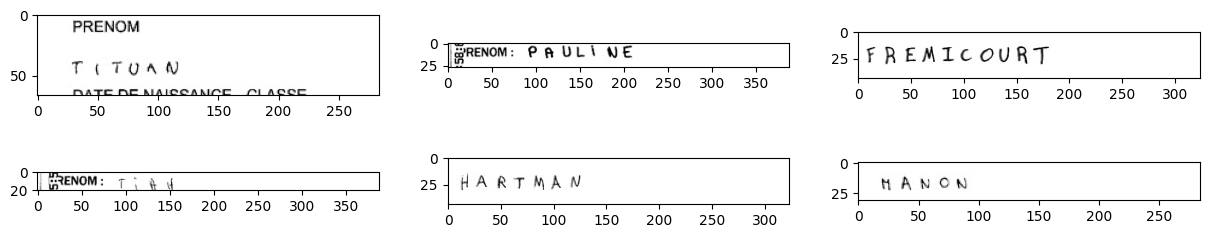

In [7]:
unreadable_indexes = train_csv[train_csv['IDENTITY'] == 'UNREADABLE'].index

plt.figure(figsize = (15,3))

offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i + offset],0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

Removing unreadable images

In [8]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']

validation_csv = validation_csv[validation_csv['IDENTITY'] != 'UNREADABLE']

test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

Calculating unique values

In [9]:
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
validation_csv['IDENTITY'] = validation_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of samples found: ", len(train_csv.values))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of samples found:  330294
Number of unique characters:  30
Characters present:  {'l', 'p', '`', 'i', 't', 'a', ' ', 's', 'n', 'x', 'j', 'u', '-', 'z', 'd', 'o', "'", 'k', 'f', 'r', 'w', 'b', 'e', 'y', 'm', 'q', 'v', 'c', 'g', 'h'}


Text processing

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

sample_sequence = tokenizer.texts_to_sequences(['sample text'])
sample_pad = pad_sequences(sample_sequence, maxlen = max_length, padding = 'post')
sample_text = tokenizer.sequences_to_texts(sample_sequence)
print("Sample sequence: ", sample_sequence[0])
print("Sample pad: ", sample_pad[0])
print("Sample text: ", sample_text[0])

img_width = 50
img_height = 200

Sample sequence:  [10, 2, 11, 18, 5, 1, 25, 8, 1, 24, 8]
Sample pad:  [10  2 11 18  5  1 25  8  1 24  8  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Sample text:  s a m p l e   t e x t


visualizing samples

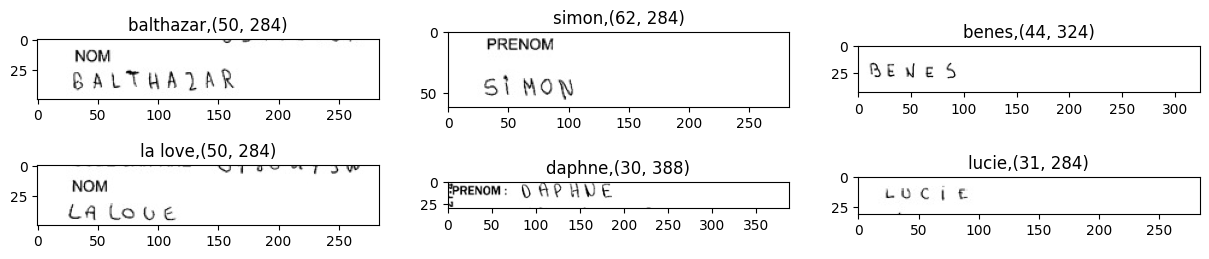

In [11]:
plt.figure(figsize = (15,3))

offset = 0
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[i + offset,0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')
    plt.title(f'{train_csv.iloc[i + offset,1]},{image.shape}')

resizing,Normalizing by dividing it by 255

In [12]:
images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(validation_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255
    
    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,label

defining lengths of data to use

In [13]:
train_length = 30000
validation_length = 3000
test_length = 3000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [14]:
x_train = []
y_train = []
train_label_len = []
for i in range(train_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

In [15]:
x_val = []
y_val = []
valid_label_len = []

for i in range(train_length, train_length+validation_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

In [16]:
x_test = []
y_test = []

for i in range(test_length):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]
    
    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [17]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((30000, 200, 50, 1), (3000, 200, 50, 1), (30000, 34), (3000, 34))

In [48]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([validation_length, 1]) * 48
valid_output = np.zeros([validation_length])

In [49]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

CNN implementation

In [50]:
input_img = layers.Input(shape=(200, 50, 1), name="image")
labels = layers.Input(name="label", shape=(max_length,))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",# negative inputs to 0
    kernel_initializer="he_normal",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)

x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",#rectified linear unit
    kernel_initializer="he_normal",#weighr initialization
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

x = layers.Reshape(target_shape=(50,768), name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)

#capturing fronnt and back
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
y_pred = layers.Dense(
    len(characters) + 1, activation="softmax", name="output"
)(x)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])
model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], 
                           outputs=loss_out,
                           name="ocr_model_v1")

In [51]:
opt = keras.optimizers.Adam()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [52]:
epochs = 10
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True

)

history = model.fit(
    x=(x_train, y_train, train_input_len, train_label_len),
    y=np.zeros([train_length]),
    validation_data=([x_val, y_val, valid_input_len, valid_label_len], np.zeros([validation_length])),
    epochs=epochs,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/10
235/235 [==============================] - 421s 2s/step - loss: 21.3862 - val_loss: 19.7484
Epoch 2/10
235/235 [==============================] - 429s 2s/step - loss: 19.3042 - val_loss: 18.8653
Epoch 3/10
235/235 [==============================] - 423s 2s/step - loss: 18.6891 - val_loss: 18.0079
Epoch 4/10
235/235 [==============================] - 417s 2s/step - loss: 16.8745 - val_loss: 14.8111
Epoch 5/10
235/235 [==============================] - 410s 2s/step - loss: 13.0913 - val_loss: 10.2739
Epoch 6/10
235/235 [==============================] - 412s 2s/step - loss: 9.0396 - val_loss: 6.4072
Epoch 7/10
235/235 [==============================] - 412s 2s/step - loss: 6.4125 - val_loss: 5.0736
Epoch 8/10
235/235 [==============================] - 427s 2s/step - loss: 5.1846 - val_loss: 4.2807
Epoch 9/10
235/235 [==============================] - 406s 2s/step - loss: 4.4564 - val_loss: 3.7408
Epoch 10/10
235/235 [==============================] - 431s 2s/step - loss: 3.978

without fit

In [ ]:
'''epochs = 10
batch_size = 128

# Create optimizer and compile the model
opt = keras.optimizers.Adam()
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

for epoch in range(epochs):
    print("Epoch:", epoch + 1)
    for batch_start in range(0, train_length, batch_size):
        batch_end = batch_start + batch_size
        
        # Prepare the batch data
        batch_x = x_train[batch_start:batch_end]
        batch_y = y_train[batch_start:batch_end]
        batch_input_len = train_input_len[batch_start:batch_end]
        batch_label_len = train_label_len[batch_start:batch_end]
        
        # Perform a single forward and backward pass
        with tf.GradientTape() as tape:
            preds = model([batch_x, batch_y, batch_input_len, batch_label_len])
            loss = tf.reduce_mean(preds)
        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Evaluate the model on the validation data after each epoch
    val_preds = model.predict([x_val, y_val, valid_input_len, valid_label_len])
    val_loss = np.mean(val_preds)
    print("Validation Loss:", val_loss)
    
    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        # Save the best weights
        model.save_weights("best_weights.h5")
    elif epoch - best_epoch >= early_stopping_patience:
        print("Early stopping triggered. Restoring best weights.")
        model.load_weights("best_weights.h5")
        break
'''

In [23]:
#import pickle
#with open('trained_model.plk','wb')as file:
 #   pickle.dump(model,file)

In [54]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

Decoding the prediction

In [55]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [63]:
preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)
test_pred_texts = decode_predictions(preds)

94/94 [==============================] - 18s 189ms/step


Calculating character error rate

In [64]:
def calculate_cer(true_text, pred_text):
    true_text = true_text.lower()
    pred_text = pred_text.lower()

    # Calculate the Levenshtein distance
    m = len(true_text)
    n = len(pred_text)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i

    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if true_text[i - 1] == pred_text[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(
                    dp[i - 1][j] + 1,  # Deletion-present in t not in p
                    dp[i][j - 1] + 1,  # Insertion-present in p not in t
                    dp[i - 1][j - 1] + 1,  # Substitution-no of char
                )

    cer = dp[m][n] / max(m, n)
    return cer


sample prediction

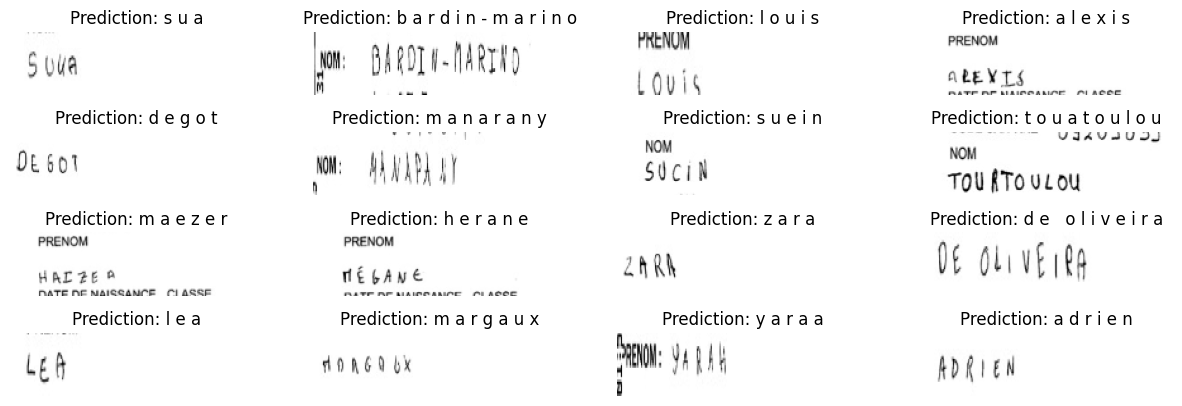

In [58]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [72]:
true_label = "margaux"
predicted_label = "marguax"
cer = calculate_cer(true_label, predicted_label)
print("Character Error Rate:", cer)
print("Accuracy:",(1-cer)*100)

Character Error Rate: 0.2857142857142857
Accuracy: 71.42857142857143


In [47]:
#model.save('trained_model.h5')


1/1 [==============================] - 0s 89ms/step


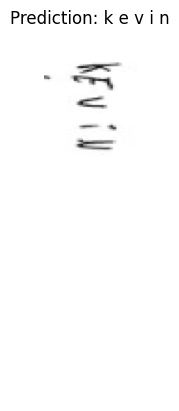

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tensorflow import keras

#load_model=joblib.load('trained_model.h5')
# Provide your own image path
#loaded_model = keras.models.load_model('trained_model.h5')

image_path = "D:/recognition/Handwritingrecognition/test_v2/test/TEST_0001.jpg"

# Load and preprocess the image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_AREA)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255
img = np.expand_dims(img, axis=2)

# Make predictions
pred = prediction_model.predict(np.expand_dims(img, axis=0))
pred_text = decode_predictions(pred)[0][0]

# Display the image and prediction
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Prediction: {pred_text}")
plt.axis("off")
plt.show()
